In [1]:
using Parameters

In [3]:
using Parameters
using Plots

@kwdef struct CompartmentHHParameter{FT}
    Cm::FT = 1.0
    gNa::FT = 120.0
    gK::FT = 36.0
    gL::FT = 0.3
    gCa::FT = 1.5
    ENa::FT = 50.0
    EK::FT = -77.0
    EL::FT = -54.0
    ECa::FT = 120.0
    gc::FT = 1.0
end

@kwdef mutable struct ActiveMultiCompartmentHH{FT}
    num_compartments::Int
    dt::FT = 1e-3
    param::CompartmentHHParameter{FT} = CompartmentHHParameter{FT}()
    v::Vector{FT} = fill(-65.0, num_compartments)
    m::Vector{FT} = fill(0.05, num_compartments)
    h::Vector{FT} = fill(0.6, num_compartments)
    n::Vector{FT} = fill(0.32, num_compartments)
    p::Vector{FT} = fill(0.0, num_compartments)  # Ca2+ チャンネルのゲート
    has_active_channels::Vector{Bool} = falses(num_compartments)
end

# 活性化/不活性化関数定義
αm(v) = 0.1 * (v + 40.0) / (1 - exp(-0.1 * (v + 40.0)))
βm(v) = 4.0 * exp(-(v + 65.0) / 18.0)
αh(v) = 0.07 * exp(-0.05 * (v + 65.0))
βh(v) = 1.0 / (1 + exp(-0.1 * (v + 35.0)))
αn(v) = 0.01 * (v + 55.0) / (1 - exp(-0.1 * (v + 55.0)))
βn(v) = 0.125 * exp(-0.0125 * (v + 65.0))
αp(v) = 1.6 / (1 + exp(-0.072 * (v - 5.0)))
βp(v) = 0.02 * (v + 8.9) / (exp((v + 8.9) / 5.0) - 1.0)

function update!(neuron::ActiveMultiCompartmentHH, Iext::Vector)
    @unpack num_compartments, dt, v, m, h, n, p, has_active_channels = neuron
    @unpack Cm, gNa, gK, gL, gCa, ENa, EK, EL, ECa, gc = neuron.param
    Vnext = copy(v)

    @inbounds for i = 1:num_compartments
        IL = gL * (v[i] - EL)
        I_coupling = 0.0
        if i > 1
            I_coupling += gc * (v[i - 1] - v[i])
        end
        if i < num_compartments
            I_coupling += gc * (v[i + 1] - v[i])
        end

        INa = IK = ICa = 0.0
        if has_active_channels[i]
            m[i] += dt * (αm(v[i]) * (1 - m[i]) - βm(v[i]) * m[i])
            h[i] += dt * (αh(v[i]) * (1 - h[i]) - βh(v[i]) * h[i])
            n[i] += dt * (αn(v[i]) * (1 - n[i]) - βn(v[i]) * n[i])
            p[i] += dt * (αp(v[i]) * (1 - p[i]) - βp(v[i]) * p[i])

            INa = gNa * m[i]^3 * h[i] * (v[i] - ENa)
            IK  = gK  * n[i]^4 * (v[i] - EK)
            ICa = gCa * p[i]^2 * (v[i] - ECa)
        end

        Vnext[i] = v[i] + dt / Cm * (Iext[i] - INa - IK - IL - ICa + I_coupling)
    end

    neuron.v .= Vnext
    return Vnext
end

update! (generic function with 1 method)

In [8]:
# 実行例
function run_simulation()
    T = 100.0
    dt = 0.01
    steps = Int(T/dt)
    N = 5
    neuron = ActiveMultiCompartmentHH{Float64}(num_compartments=N, dt=dt)
    neuron.has_active_channels .= [true, false, false, false, false]  # somaと末端に活動チャンネル

    vs = zeros(Float64, steps, N)
    Is = zeros(Float64, N)
    Is[1] = 10.0  # somaに刺激

    for t in 1:steps
        update!(neuron, Is)
        vs[t, :] .= neuron.v
    end

    plot(vs, xlabel="Time step", ylabel="Membrane potential (mV)", label=["v₁" "v₂" "v₃" "v₄" "v₅"], title="bAP propagation")
end

run_simulation (generic function with 1 method)

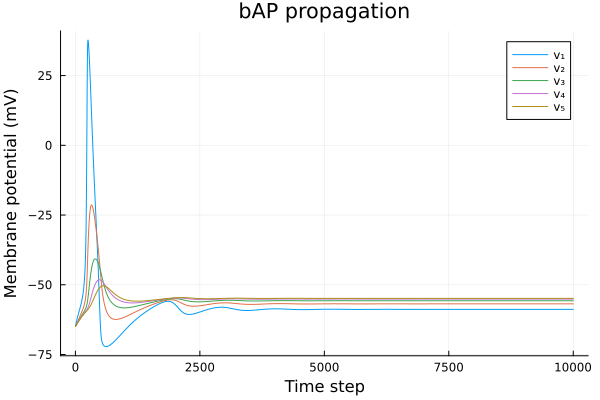

In [9]:
run_simulation()